# __SpringBoard Capstone Project 2: Human Activity Recognition__
## __Deep Learning__

__Written by: Sofy Weisenberg__<br>
__Date: 04/21/20__

__Importing the Data__<br>
Load the data from file into a pandas dataframe. In previous sections, the dataset used had undergone feature engineering (with 9 signal time series transformed into 561 features for each 2.56 s window of the time series). Implementing a deep learning approach will require switching to the raw data in order to allow the network to find its own features in the data. 

Therefore, the raw data will need to be loaded into an appropriately sized feature array X. The label vector y from previous sections remains the same. 

Each row/observation still represents a single 2.56 s window, and these windows still have 50% overlap per the design of the collected data. However, now each row contains 128 time steps of raw signal data (50 Hz x 2.56 s). A row with 128 columns exists for each of the 9 signal channels:

- body acceleration (x,y,z)
- body gyroscope (x,y,z)
- total acceletation (x,y,z)

Therefore, when combining all the signal data, each row should actually have 128 x 9 = 1152 columns or features. The 9 channels of data are stored in 9 separate files and are already separated into training and test sets (see "Splitting the Data: Training and Test Sets" in the previous section).

__Categorical Class Encoding__

Since the class labels (Activity column) for this data are in a categorical string format, they must first be encoded to a numerical format useable for supervised machine learning. Simple integer encoding (i.e. translating each class label into an integer label 1-6) would not be effective on its own in this case, since such an encoding implies an ordinal relationship between the classes, where in reality there is none. This may result in poor model performance or unexpected results.

Integer encoding followed by one-hot encoding is the preferred method to transform the categorical data. Each integer class label is assigned to a new binary (0/1) column of "dummy variables". Each observation in the dataset is then be labeled with a 1 in only one of these "dummy variable" columns and the rest are labeled with a 0, resulting in sparse matrices of class labels for y_train and y_test. 

In [6]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import os
import time
import tensorflow as tf
from tensorflow import keras

# Use the current working directory path to navigate to the location of the processed data
cwd_path = os.getcwd()
data_path = os.path.join(cwd_path, '..', 'data', 'raw')

# Throw an assert error if the path does not exist
assert os.path.exists(data_path)

The code for loading the data was modified from the guide found here:
https://machinelearningmastery.com/how-to-develop-rnn-models-for-human-activity-recognition-time-series-classification/

In [7]:
# load a single file as a numpy array
def load_file(filepath):
    df = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return df.values

In [8]:
# load all channels into a stacked 3D array
def load_files_3D_array(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(os.path.join(prefix, name))
        loaded.append(data)
    
    # stack array so that features are the 3rd dimension
    loaded = np.dstack(loaded)
    return loaded

In [9]:
# load a dataset group, specify group = 'train' or 'test', prefix is location of group data folder
def load_dataset_group(group, prefix=''):
    
    filepath = os.path.join(prefix, group, 'Inertial Signals')
    
    # list all 9 filenames in group (train/test)
    filenames = list()
    # body acceleration
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    # body gyroscope
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    # total acceleration
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    
    # load 3D stacked feature array for group (train/test)
    X = load_files_3D_array(filenames, filepath)
    # load class output array for group (train/test)
    y = load_file(os.path.join(prefix, group, 'y_'+group+'.txt'))
    
    return X, y

In [10]:
from tensorflow.keras.utils import to_categorical

# load the entire dataset, prefix is filepath of dataset folder
# returns train and test stacked feature array X and class output array y (one-hot encoded) for train, test groups
def load_dataset(prefix=''):
    
    # load all training set
    X_train, y_train = load_dataset_group('train', prefix)
    
    # load all test set
    X_test, y_test = load_dataset_group('test', prefix)
    
    # zero-offset class values (transform integers 1-6 to integers 0-5 for one-hot encoding)
    y_train = y_train - 1
    y_test = y_test - 1
    # one hot encode y
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)
    
    print('Training feature array X size, training label vector y size:')
    print(X_train.shape, y_train.shape)
    print('\nTest feature array X size, test label vector y size:')
    print(X_test.shape, y_test.shape)
    
    return X_train, y_train, X_test, y_test

In [11]:
X_train, y_train, X_test, y_test = load_dataset(data_path)

Training feature array X size, training label vector y size:
(7352, 128, 9) (7352, 6)

Test feature array X size, test label vector y size:
(2947, 128, 9) (2947, 6)


__Feature Scaling__<br>
To improve performance of the machine learning model(s) to be applied to this classification problem, first the feature data should be appropriately scaled.

Scaling must be performed both on the training and test data sets in the same manner. Best practice is to use only the training set to identify the correct scaling, and then blindly apply the same transformation to the test set. Scaling all features to a [0,1] range is a common scaling method for neural network preprocessing and may be applied using the MinMaxScaler() transformation method from sklearn. 

However, after evaluating the model with [0,1] scaling, poor performance was observed (approx. 0.78 accuracy). MinMaxScaler() with range [1,1] scaling performed much better (approx. 0.89 accuracy) and StandardScaler() with mean centered around 0 and std. dev = 1 performed even slightly better (approx. 0.91 accuracy). Therefore, the StandardScaler() method was selected for feature scaling.

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# initialize scaled feature arrays 
X_train_scaled = np.empty(X_train.shape)
X_test_scaled = np.empty(X_test.shape)

# initialize scaler function
#scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = StandardScaler()

# scaler only accepts 2D arrays, so loop over 9 2D arrays to fit and transform accordingly for each
for i in range(X_train.shape[2]):
    scaler.fit(X_train[:,:,i])
    X_train_scaled[:,:,i] = scaler.transform(X_train[:,:,i])
    X_test_scaled[:,:,i] = scaler.transform(X_test[:,:,i])

The scaling transformation has been performed successfully on both the training and test feature sets. <br>
- The mean for each column in the X_train_scaled feature array is 0, and std. dev is 1. <br>
- The mean for each column in the X_test_scaled feature array is NOT 0, and std. dev is NOT 1, since a transformation matrix (generated from normalizing the training feature matrix range) was applied to the test feature matrix.

__Fitting an RNN Model__<br>
Now that the data has been loaded and preprocessing completed, a deep learning model may be trained on the data. The first model that will be implemented is a Recurrent Neural Network (RNN) which leverages the sequential nature of the time series signal data from the 9 different channels. Specifically, the LSTM (long short term memory) layer of the neural network, unlike feed forward neural network architectures, has feedback mechanisms that allow previous observations in the sequence to be "remembered" by the network.

First, a basic network architecture will be established. Then several network hyperparameters will be optimized using a grid search optimization. 

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM

# establish a basic network architecture for the model, fit and evaluate the model for a given train/test dataset
def evaluate_model(X_train, y_train, X_test, y_test):
    verbose, epochs, batch_size = 0, 15, 64
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
    model = Sequential()
    model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    #model.add(Dense(100, activation='relu'))
    model.add(Dense(100, kernel_initializer='glorot_uniform', activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    # fit network
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)
    return accuracy

In [9]:
# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = np.mean(scores), np.std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))
 
# run an experiment
def run_experiment(repeats=1):
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)
 
# run the experiment
# run_experiment()

In [14]:
# Use scikit-learn to grid search the network hyperparameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

# Function to create model, required for KerasClassifier

def create_RNN_model(neurons=100, dropout=0.5, batch_size=64):
    # Define key array lengths 
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
    
    # Define input layer and hidden layers
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(n_timesteps, n_features)))
    model.add(Dropout(dropout))
    model.add(Dense(neurons, kernel_initializer='glorot_uniform', activation='relu'))
    
    # Define output layer with multiple outputs and compile model
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [15]:
# create model with early stopping monitor (if model convergence reached before n_epochs)
n_epochs = 35
model = KerasClassifier(build_fn=create_RNN_model, verbose=0, epochs=n_epochs)
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)

# define the grid search parameters
neurons = [50, 100, 200]
dropout = [0.1,0.3,0.5]
batch_size = [32, 64, 128]

# neurons = [100]
# dropout = [0.5]
# batch_size = [64]
param_grid = dict(neurons=neurons, 
                  dropout=dropout, 
                  batch_size=batch_size)

# run grid search and report results and early stopping
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1, n_jobs=1)

In [73]:
from joblib import Parallel, delayed
# results = Parallel(n_jobs=2, verbose=5)(
#     delayed(test_data)(data) for _ in range(10))

# grid_result = Parallel(n_jobs=8, verbose=5)(delayed(grid.fit(X_train_scaled, y_train, callbacks=[es])))
grid_result = grid.fit(X_train_scaled, y_train, callbacks=[es])


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 00015: early stopping
Epoch 00017: early stopping
Epoch 00016: early stopping
Epoch 00021: early stopping
Epoch 00018: early stopping
Epoch 00019: early stopping
Epoch 00014: early stopping
Epoch 00018: early stopping
Epoch 00028: early stopping
Epoch 00023: early stopping
Epoch 00016: early stopping
Epoch 00015: early stopping
Epoch 00019: early stopping
Epoch 00028: early stopping
Epoch 00015: early stopping
Epoch 00010: early stopping
Epoch 00028: early stopping
Epoch 00027: early stopping
Epoch 00017: early stopping
Epoch 00032: early stopping
Epoch 00009: early stopping
Epoch 00012: early stopping
Epoch 00014: early stopping
Epoch 00013: early stopping
Epoch 00015: early stopping
Epoch 00017: early stopping
Epoch 00013: early stopping
Epoch 00020: early stopping
Epoch 00014: early stopping
Epoch 00022: early stopping
Epoch 00013: early stopping
Epoch 00016: early stopping
Epoch 00026: early stopping
Epoch 00013: early stopping
Epoch 00016: early stopping
Epoch 00021: early s

[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 238.7min finished


Epoch 00020: early stopping


In [74]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.937023 using {'batch_size': 64, 'dropout': 0.5, 'neurons': 100}
0.922605 (0.020585) with: {'batch_size': 32, 'dropout': 0.1, 'neurons': 50}
0.929542 (0.007195) with: {'batch_size': 32, 'dropout': 0.1, 'neurons': 100}
0.927364 (0.019752) with: {'batch_size': 32, 'dropout': 0.1, 'neurons': 200}
0.922605 (0.021351) with: {'batch_size': 32, 'dropout': 0.3, 'neurons': 50}
0.922469 (0.022381) with: {'batch_size': 32, 'dropout': 0.3, 'neurons': 100}
0.923560 (0.022284) with: {'batch_size': 32, 'dropout': 0.3, 'neurons': 200}
0.913903 (0.033620) with: {'batch_size': 32, 'dropout': 0.5, 'neurons': 50}
0.862765 (0.056145) with: {'batch_size': 32, 'dropout': 0.5, 'neurons': 100}
0.906959 (0.038548) with: {'batch_size': 32, 'dropout': 0.5, 'neurons': 200}
0.899208 (0.021618) with: {'batch_size': 64, 'dropout': 0.1, 'neurons': 50}
0.927640 (0.019723) with: {'batch_size': 64, 'dropout': 0.1, 'neurons': 100}
0.930904 (0.019384) with: {'batch_size': 64, 'dropout': 0.1, 'neurons': 200}
0.913763

In [75]:
def show_train_history(train_history,n_epochs,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History: %i epochs' % n_epochs)
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.xticks(np.arange(0, n_epochs, step=round(n_epochs/10)))
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

In [76]:
model = create_RNN_model(neurons=grid_result.best_params_['neurons'], 
                     dropout=grid_result.best_params_['dropout'], 
                     batch_size=grid_result.best_params_['batch_size'])
train_history = model.fit(x=X_train_scaled, y=y_train,  
                          validation_split=0.25, 
                          epochs=n_epochs, 
                          batch_size=grid_result.best_params_['batch_size'], 
                          verbose=2,
                          callbacks=[es])


Train on 5514 samples, validate on 1838 samples
Epoch 1/35
5514/5514 - 14s - loss: 0.9982 - accuracy: 0.6099 - val_loss: 0.5149 - val_accuracy: 0.8074
Epoch 2/35
5514/5514 - 12s - loss: 0.4362 - accuracy: 0.8330 - val_loss: 0.4335 - val_accuracy: 0.8645
Epoch 3/35
5514/5514 - 12s - loss: 0.3342 - accuracy: 0.8814 - val_loss: 0.2817 - val_accuracy: 0.9032
Epoch 4/35
5514/5514 - 12s - loss: 0.2166 - accuracy: 0.9258 - val_loss: 0.1907 - val_accuracy: 0.9325
Epoch 5/35
5514/5514 - 12s - loss: 0.1423 - accuracy: 0.9496 - val_loss: 0.1851 - val_accuracy: 0.9380
Epoch 6/35
5514/5514 - 12s - loss: 0.1380 - accuracy: 0.9460 - val_loss: 0.1887 - val_accuracy: 0.9380
Epoch 7/35
5514/5514 - 12s - loss: 0.1398 - accuracy: 0.9454 - val_loss: 0.1929 - val_accuracy: 0.9282
Epoch 8/35
5514/5514 - 12s - loss: 0.1315 - accuracy: 0.9487 - val_loss: 0.2031 - val_accuracy: 0.9331
Epoch 9/35
5514/5514 - 12s - loss: 0.1284 - accuracy: 0.9432 - val_loss: 0.1931 - val_accuracy: 0.9391
Epoch 10/35
5514/5514 - 1

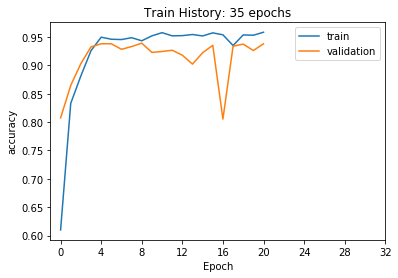

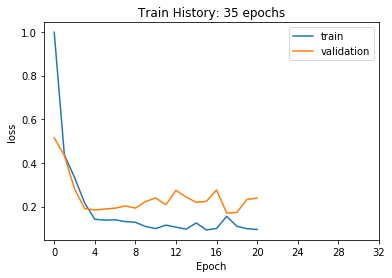

In [77]:
show_train_history(train_history,n_epochs,'accuracy','val_accuracy')
show_train_history(train_history,n_epochs,'loss','val_loss')

In [16]:
# define function for creating labeled confusion matrix for multiclass identification
def labeled_confusion_mat(true_vector, pred_vector, labels):
    confusion_matrix_labeled = pd.DataFrame(confusion_matrix(true_vector, pred_vector))
    confusion_matrix_labeled.columns = list(labels)
    confusion_matrix_labeled.index = list(labels)
    return confusion_matrix_labeled

In [79]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# evaluate RNN model on test set using .predict() and then revert to integer class label encoding
y_test_pred_encoded = model.predict(X_test_scaled)
y_test_pred = np.argmax(y_test_pred_encoded, axis =1)
y_test_act = np.argmax(y_test, axis =1)

labels = ['LAY', 'SIT', 'STA', 'WALK', 'WALK_D', 'WALK_U']
print('Confusion matrix for RNN evaluation on training set:\n')
print(labeled_confusion_mat(y_test_act, y_test_pred, labels))
print('\nClassification report for RNN evaluation on training set:\n')
print(classification_report(y_test_act, y_test_pred, target_names=labels))

Confusion matrix for RNN evaluation on training set:

        LAY  SIT  STA  WALK  WALK_D  WALK_U
LAY     463    7   26     0       0       0
SIT       2  451   16     2       0       0
STA       0    0  420     0       0       0
WALK      0   21    0   408      57       5
WALK_D    0    2    0    65     465       0
WALK_U    0   19    0     0       0     518

Classification report for RNN evaluation on training set:

              precision    recall  f1-score   support

         LAY       1.00      0.93      0.96       496
         SIT       0.90      0.96      0.93       471
         STA       0.91      1.00      0.95       420
        WALK       0.86      0.83      0.84       491
      WALK_D       0.89      0.87      0.88       532
      WALK_U       0.99      0.96      0.98       537

    accuracy                           0.92      2947
   macro avg       0.92      0.93      0.92      2947
weighted avg       0.93      0.92      0.92      2947



__CNN LSTM Model__

In [17]:
# Use scikit-learn to grid search the network hyperparameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

# Define key array lengths 
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# reshape data into time steps of sub-sequences
n_steps, n_length = 4, 32
X_train_reshaped = X_train_scaled.reshape((X_train.shape[0], n_steps, n_length, n_features))
X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], n_steps, n_length, n_features))

# Function to create model, required for KerasClassifier
def create_CNN_LSTM_model(neurons=100, dropout=0.5, batch_size=64):
    # define model
    #verbose, epochs, batch_size = 0, 25, 64

    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(dropout)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(neurons))
    model.add(Dropout(dropout))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [18]:
# create model with early stopping monitor (if model convergence reached before n_epochs)
n_epochs = 35
model = KerasClassifier(build_fn=create_CNN_LSTM_model, verbose=0, epochs=n_epochs)
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)

# define the grid search parameters
neurons = [50, 100, 200]
dropout = [0.1,0.3,0.5]
batch_size = [32, 64, 128]

# neurons = [100]
# dropout = [0.5]
# batch_size = [64]
#filters = [64]
#kernel_size = [3]
param_grid = dict(neurons=neurons, 
                  dropout=dropout, 
                  batch_size=batch_size)
                  #filters = filters,
                  #kernel_size = kernel_size)

# run grid search and report results and early stopping
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1, n_jobs=1)

In [19]:
from joblib import Parallel, delayed
# results = Parallel(n_jobs=2, verbose=5)(
#     delayed(test_data)(data) for _ in range(10))

# grid_result = Parallel(n_jobs=8, verbose=5)(delayed(grid.fit(X_train_scaled, y_train, callbacks=[es])))
grid_result = grid.fit(X_train_reshaped, y_train, callbacks=[es])


Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 00026: early stopping
Epoch 00031: early stopping
Epoch 00030: early stopping
Epoch 00017: early stopping
Epoch 00035: early stopping
Epoch 00022: early stopping
Epoch 00021: early stopping
Epoch 00023: early stopping
Epoch 00030: early stopping
Epoch 00028: early stopping
Epoch 00028: early stopping
Epoch 00029: early stopping
Epoch 00027: early stopping
Epoch 00030: early stopping
Epoch 00023: early stopping
Epoch 00020: early stopping
Epoch 00034: early stopping
Epoch 00025: early stopping
Epoch 00025: early stopping
Epoch 00033: early stopping
Epoch 00033: early stopping
Epoch 00034: early stopping
Epoch 00033: early stopping
Epoch 00032: early stopping
Epoch 00019: early stopping
Epoch 00026: early stopping
Epoch 00033: early stopping
Epoch 00028: early stopping
Epoch 00029: early stopping
Epoch 00026: early stopping


[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 76.7min finished


In [20]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.940969 using {'batch_size': 64, 'dropout': 0.1, 'neurons': 200}
0.922063 (0.024809) with: {'batch_size': 32, 'dropout': 0.1, 'neurons': 50}
0.929545 (0.024330) with: {'batch_size': 32, 'dropout': 0.1, 'neurons': 100}
0.929817 (0.026640) with: {'batch_size': 32, 'dropout': 0.1, 'neurons': 200}
0.928865 (0.021968) with: {'batch_size': 32, 'dropout': 0.3, 'neurons': 50}
0.912134 (0.030992) with: {'batch_size': 32, 'dropout': 0.3, 'neurons': 100}
0.932808 (0.012928) with: {'batch_size': 32, 'dropout': 0.3, 'neurons': 200}
0.926009 (0.018422) with: {'batch_size': 32, 'dropout': 0.5, 'neurons': 50}
0.937432 (0.010236) with: {'batch_size': 32, 'dropout': 0.5, 'neurons': 100}
0.937160 (0.014038) with: {'batch_size': 32, 'dropout': 0.5, 'neurons': 200}
0.930497 (0.012188) with: {'batch_size': 64, 'dropout': 0.1, 'neurons': 50}
0.920702 (0.008562) with: {'batch_size': 64, 'dropout': 0.1, 'neurons': 100}
0.940969 (0.005572) with: {'batch_size': 64, 'dropout': 0.1, 'neurons': 200}
0.929134

In [21]:
def show_train_history(train_history,n_epochs,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History: %i epochs' % n_epochs)
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.xticks(np.arange(0, n_epochs, step=round(n_epochs/10)))
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

In [22]:
model = create_CNN_LSTM_model(neurons=grid_result.best_params_['neurons'], 
                     dropout=grid_result.best_params_['dropout'], 
                     batch_size=grid_result.best_params_['batch_size'])
train_history = model.fit(x=X_train_reshaped, y=y_train,  
                          validation_split=0.25, 
                          epochs=n_epochs, 
                          batch_size=grid_result.best_params_['batch_size'], 
                          verbose=2,
                          callbacks=[es])


Train on 5514 samples, validate on 1838 samples
Epoch 1/35
5514/5514 - 4s - loss: 0.4284 - accuracy: 0.8225 - val_loss: 0.2469 - val_accuracy: 0.9331
Epoch 2/35
5514/5514 - 3s - loss: 0.1064 - accuracy: 0.9512 - val_loss: 0.1948 - val_accuracy: 0.9423
Epoch 3/35
5514/5514 - 3s - loss: 0.0963 - accuracy: 0.9541 - val_loss: 0.2379 - val_accuracy: 0.9347
Epoch 4/35
5514/5514 - 3s - loss: 0.0842 - accuracy: 0.9597 - val_loss: 0.2303 - val_accuracy: 0.9505
Epoch 5/35
5514/5514 - 3s - loss: 0.0751 - accuracy: 0.9585 - val_loss: 0.3099 - val_accuracy: 0.9287
Epoch 6/35
5514/5514 - 3s - loss: 0.0752 - accuracy: 0.9632 - val_loss: 0.2611 - val_accuracy: 0.9407
Epoch 7/35
5514/5514 - 3s - loss: 0.0696 - accuracy: 0.9617 - val_loss: 0.2837 - val_accuracy: 0.9151
Epoch 8/35
5514/5514 - 3s - loss: 0.0591 - accuracy: 0.9688 - val_loss: 0.3134 - val_accuracy: 0.9320
Epoch 9/35
5514/5514 - 3s - loss: 0.0613 - accuracy: 0.9717 - val_loss: 0.3516 - val_accuracy: 0.9450
Epoch 10/35
5514/5514 - 3s - loss:

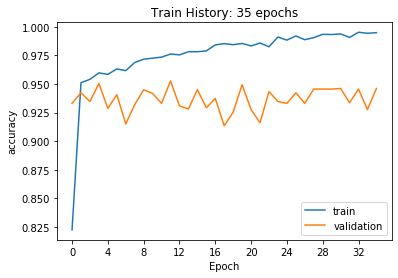

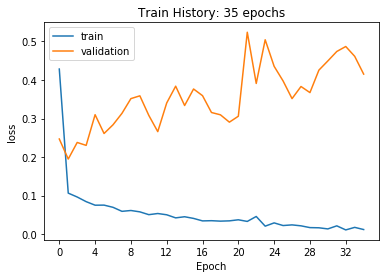

In [23]:
show_train_history(train_history,n_epochs,'accuracy','val_accuracy')
show_train_history(train_history,n_epochs,'loss','val_loss')

In [24]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# evaluate model on test set using .predict() and then revert to integer class label encoding
y_test_pred_encoded = model.predict(X_test_reshaped)
y_test_pred = np.argmax(y_test_pred_encoded, axis =1)
y_test_act = np.argmax(y_test, axis =1)

labels = ['LAY', 'SIT', 'STA', 'WALK', 'WALK_D', 'WALK_U']
print('Confusion matrix for CNN LSTM evaluation on test set:\n')
print(labeled_confusion_mat(y_test_act, y_test_pred, labels))
print('\nClassification report for CNN LSTM evaluation on test set:\n')
print(classification_report(y_test_act, y_test_pred, target_names=labels))

Confusion matrix for CNN LSTM evaluation on test set:

        LAY  SIT  STA  WALK  WALK_D  WALK_U
LAY     461    0   35     0       0       0
SIT       0  449   20     2       0       0
STA       2   12  406     0       0       0
WALK      0    5    0   390      96       0
WALK_D    0    0    0    51     481       0
WALK_U    0   27    0     0       0     510

Classification report for CNN LSTM evaluation on test set:

              precision    recall  f1-score   support

         LAY       1.00      0.93      0.96       496
         SIT       0.91      0.95      0.93       471
         STA       0.88      0.97      0.92       420
        WALK       0.88      0.79      0.84       491
      WALK_D       0.83      0.90      0.87       532
      WALK_U       1.00      0.95      0.97       537

    accuracy                           0.92      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.92      0.92      2947



__ConvLSTM Model__

In [91]:
# Use scikit-learn to grid search the network hyperparameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping

# Define key array lengths 
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
# reshape data into time steps of sub-sequences
n_steps, n_length = 4, 32
X_train_reshaped = X_train_scaled.reshape((X_train.shape[0], n_steps, n_length, n_features))
X_test_reshaped = X_test_scaled.reshape((X_test.shape[0], n_steps, n_length, n_features))

# Function to create model, required for KerasClassifier
def create_ConvLSTM_model(neurons=100, dropout=0.5, batch_size=64):
    # define model
    #verbose, epochs, batch_size = 0, 25, 64

    # define model
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None,n_length,n_features)))
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
    model.add(TimeDistributed(Dropout(dropout)))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(neurons))
    model.add(Dropout(dropout))
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

In [92]:
# create model with early stopping monitor (if model convergence reached before n_epochs)
n_epochs = 35
model = KerasClassifier(build_fn=create_CNN_LSTM_model, verbose=0, epochs=n_epochs)
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)

# define the grid search parameters
#neurons = [50, 100, 200]
#dropout = [0.1,0.3,0.5]
#batch_size = [32, 64, 128]

neurons = [100]
dropout = [0.5]
batch_size = [64]
#filters = [64]
#kernel_size = [3]
param_grid = dict(neurons=neurons, 
                  dropout=dropout, 
                  batch_size=batch_size)
                  #filters = filters,
                  #kernel_size = kernel_size)

# run grid search and report results and early stopping
# grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3, verbose=1)
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1, n_jobs=1)

In [93]:
from joblib import Parallel, delayed
# results = Parallel(n_jobs=2, verbose=5)(
#     delayed(test_data)(data) for _ in range(10))

# grid_result = Parallel(n_jobs=8, verbose=5)(delayed(grid.fit(X_train_scaled, y_train, callbacks=[es])))
grid_result = grid.fit(X_train_reshaped, y_train, callbacks=[es])


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 00032: early stopping
Epoch 00020: early stopping


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.7min finished


In [94]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.934033 using {'batch_size': 64, 'dropout': 0.5, 'neurons': 100}
0.934033 (0.019603) with: {'batch_size': 64, 'dropout': 0.5, 'neurons': 100}


In [95]:
def show_train_history(train_history,n_epochs,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History: %i epochs' % n_epochs)
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.xticks(np.arange(0, n_epochs, step=round(n_epochs/10)))
    plt.legend(['train', 'validation'], loc='best')
    plt.show()

In [99]:
model = create_ConvLSTM_model(neurons=grid_result.best_params_['neurons'], 
                     dropout=grid_result.best_params_['dropout'], 
                     batch_size=grid_result.best_params_['batch_size'])
train_history = model.fit(x=X_train_reshaped, y=y_train,  
                          validation_split=0.25, 
                          epochs=n_epochs, 
                          batch_size=grid_result.best_params_['batch_size'], 
                          verbose=2,
                          callbacks=[es])


Train on 5514 samples, validate on 1838 samples
Epoch 1/35
5514/5514 - 4s - loss: 0.6257 - accuracy: 0.7456 - val_loss: 0.2916 - val_accuracy: 0.8874
Epoch 2/35
5514/5514 - 3s - loss: 0.1656 - accuracy: 0.9343 - val_loss: 0.1972 - val_accuracy: 0.9347
Epoch 3/35
5514/5514 - 3s - loss: 0.1169 - accuracy: 0.9532 - val_loss: 0.2374 - val_accuracy: 0.9293
Epoch 4/35
5514/5514 - 3s - loss: 0.1017 - accuracy: 0.9563 - val_loss: 0.2111 - val_accuracy: 0.9374
Epoch 5/35
5514/5514 - 3s - loss: 0.0901 - accuracy: 0.9581 - val_loss: 0.2153 - val_accuracy: 0.9402
Epoch 6/35
5514/5514 - 3s - loss: 0.0809 - accuracy: 0.9603 - val_loss: 0.2192 - val_accuracy: 0.9200
Epoch 7/35
5514/5514 - 3s - loss: 0.0823 - accuracy: 0.9596 - val_loss: 0.2057 - val_accuracy: 0.9418
Epoch 8/35
5514/5514 - 3s - loss: 0.0683 - accuracy: 0.9635 - val_loss: 0.2555 - val_accuracy: 0.9407
Epoch 9/35
5514/5514 - 3s - loss: 0.0726 - accuracy: 0.9663 - val_loss: 0.2359 - val_accuracy: 0.9412
Epoch 10/35
5514/5514 - 3s - loss:

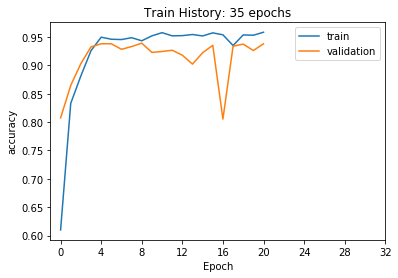

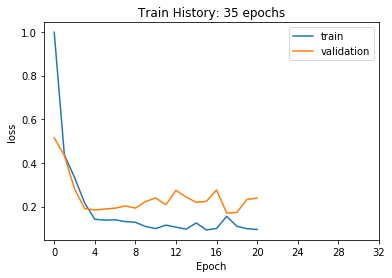

In [96]:
show_train_history(train_history,n_epochs,'accuracy','val_accuracy')
show_train_history(train_history,n_epochs,'loss','val_loss')

In [107]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# evaluate model on test set using .predict() and then revert to integer class label encoding
y_test_pred_encoded = model.predict(X_test_reshaped)
y_test_pred = np.argmax(y_test_pred_encoded, axis =1)
y_test_act = np.argmax(y_test, axis =1)

labels = ['LAY', 'SIT', 'STA', 'WALK', 'WALK_D', 'WALK_U']
print('Confusion matrix for ConvLSTM evaluation on test set:\n')
print(labeled_confusion_mat(y_test_act, y_test_pred, labels))
print('\nClassification report for ConvLSTM evaluation on test set:\n')
print(classification_report(y_test_act, y_test_pred, target_names=labels))

Confusion matrix for CNN LSTM evaluation on training set:

        LAY  SIT  STA  WALK  WALK_D  WALK_U
LAY     475    2   19     0       0       0
SIT       5  442   24     0       0       0
STA       2    0  418     0       0       0
WALK      0    1    0   374     110       6
WALK_D    0    0    0    50     482       0
WALK_U    0    0    0     0       0     537

Classification report for CNN LSTM evaluation on training set:

              precision    recall  f1-score   support

         LAY       0.99      0.96      0.97       496
         SIT       0.99      0.94      0.97       471
         STA       0.91      1.00      0.95       420
        WALK       0.88      0.76      0.82       491
      WALK_D       0.81      0.91      0.86       532
      WALK_U       0.99      1.00      0.99       537

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



__Visualizing Misclassified Activities__<br>
To better understand the limitations of the RNN model, it is helpful to visualize some of the signal data from activity instances that were misclassified by the model.